In [5]:
import cv2
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.externals import joblib
from sklearn import cluster
import sklearn.manifold
import matplotlib.patches as patches
import copy
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms,utils

In [6]:
os.getcwd()

'/app'

In [7]:
class transfer_feature_extractor():
    def __init__(self,data, bbox, label, crops,root,file, load = True):
        
        if os.path.exists(root+"/"+file+"_trans_feat.npz") and load:
            
            data = np.load(root+"/"+file+"_trans_feat.npz")
            
            self.VggNet_feat = data["VggNet"]
            self.ResNet_feat = data["ResNet"]
            self.data = data["data"]
            self.bbox = data["bbox"]
            self.label = data["label"]
        else:
            self.data = data
            self.bbox = bbox
            self.label = label
            
            self.crops = self.Normalize_split(crops)
            
            self.VggNet_feat = self.VGG_feat(self.crops)
            self.ResNet_feat = self.ResNet_feat(self.crops)
            np.savez( root+"/"+file+"_trans_feat.npz", VggNet = self.VggNet_feat, ResNet = self.ResNet_feat, 
                     data = self.data, bbox = self.bbox, label = self.label )
            
        '''
        if os.path.exists(root+"/"+file+"_Scat_feat.npz") and load:
            data_s = np.load(root+"/"+file+"_Scat_feat.npz")
            self.ScatX = data_s["Scat"]
        else:
            if os.path.exists(root+"/Scatfeatures/"+file+".npy"):
                self.filt_idx = self.separate_variance_filter_idx(X,y,group)
                self.ScatX = np.load(root+"/Scatfeatures/"+file+".npy")[self.filt_idx]
                np.savez( root+"/"+file+"_Scat_feat.npz", Scat = self.ScatX )
            else:
                print("No scat feature found")
        '''
    def Normalize_res(self, X):
        X_norm = X -  np.average(X,axis = (1,2))[:,np.newaxis,np.newaxis,:]
        stds = np.std(X_norm,axis = (1,2)) / np.array( [0.229, 0.224, 0.225] )
        # / stds[:,np.newaxis,np.newaxis,:]  - means_fix[np.newaxis,np.newaxis,np.newaxis,:]
        X_norm = np.minimum( np.maximum( X_norm/stds[:,np.newaxis,np.newaxis,:]+np.array( [0.485, 0.456, 0.406] ), 0 ),1 )
        return  X_norm
    def Normalize_split(self, X):
        num =  X.shape[0]//100
        if num < 1:
            num = 1
        X_split = np.array_split(np.arange(len(X)),num)
        for i,x_t in enumerate(X_split):
            xs = X[x_t]
            print("Normalize "+str(i)+"/"+str(num))
            if i == 0:
                feat = self.Normalize_res(xs)
            else:
                feat = np.concatenate( ( feat, self.Normalize_res(xs) ), axis=0 )
        return feat  
    def ResNet_feat(self,X):
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model_conv = nn.Sequential(*list(torchvision.models.resnet18(pretrained=True).children())[:-1]).cuda().float()
        for param in model_conv.parameters():
            param.requires_grad = False
        model_conv = model_conv.to(device)
        model_conv.eval()


        num = X.shape[0]//100
        if num < 1:
            num = 1
        X_split = np.array_split(np.arange(len(X)),num)

        for i,x_t in enumerate(X_split):
            xs = torch.from_numpy(X[x_t].transpose(0,3,1,2)).type(torch.cuda.FloatTensor)
            print("ResNet "+str(i)+"/"+str(num))
            if i == 0:

                feat = np.squeeze(model_conv(xs).cpu().numpy())
            else:
                feat = np.concatenate( ( feat, np.squeeze(model_conv(xs).cpu().numpy()) ), axis=0 )
        return feat    
    def VGG_feat(self,X):
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        model_conv = torchvision.models.vgg16(pretrained=True).cuda().float()
        
        model_conv.classifier = nn.Sequential(*list(model_conv.classifier.children())[:-3])
        for param in model_conv.parameters():
            param.requires_grad = False
        model_conv = model_conv.to(device)
        model_conv.eval()
        
        num = X.shape[0]//100
        if num < 1:
            num = 1
        X_split = np.array_split(np.arange(len(X)),num)

        for i,x_t in enumerate(X_split):
            xs = torch.from_numpy(X[x_t].transpose(0,3,1,2)).type(torch.cuda.FloatTensor)
            print("VGGNet "+str(i)+"/"+str(num))
            if i == 0:

                feat = np.squeeze(model_conv(xs).cpu().numpy())
            else:
                feat = np.concatenate( ( feat, np.squeeze(model_conv(xs).cpu().numpy()) ), axis=0 )
        return feat 
 
        
        
def get_Crops_sqa(img, data, box):
    SquareBoxSize = np.maximum(  np.array(box)[:,0],np.array(box)[:,1] )
    crops = []
    for i in range( len(data) ):
        x = data[i][0] 
        y = data[i][1]
        h = SquareBoxSize[i]

        


        h= int( np.min ( [img.shape[1] - x, x, img.shape[0] - y,  y,  h ] ) )
 
        #print(  x - h/2 )
        x_start = int( x - h/2 )
        y_start = int( y - h/2 )
        x_end = int( x + h/2 )
        y_end = int( y + h/2 )

        #print(x_start, x_end)

        crop_p = img[   y_start:y_end, x_start:x_end ]
        #print(crop_p.shape)
        crop_p = cv2.resize(crop_p, (224, 224), interpolation=cv2.INTER_CUBIC)

        crops.append( crop_p)
        
    crops = np.array( crops )
    return crops
def get_Crops(img, data, box):
    #SquareBoxSize = np.maximum(  np.array(box)[:,0],np.array(box)[:,1] )
    crops = []
    for i in range( len(data) ):
        x = data[i][0] 
        y = data[i][1]
        #h = SquareBoxSize[i]
        w = box[i][0]
        h = box[i][1]
        
        


        #h= int( np.min ( [img.shape[1] - x, x, img.shape[0] - y,  y,  h ] ) )
 
        #print(  x - h/2 )
        x_start = int( x - w/2 )
        y_start = int( y - h/2 )
        x_end = int( x + w/2 )
        y_end = int( y + h/2 )

        #print(x_start, x_end)

        crop_p = img[   y_start:y_end, x_start:x_end ]
        #print(crop_p.shape)
        crop_p = cv2.resize(crop_p, (224, 224), interpolation=cv2.INTER_CUBIC)

        crops.append( crop_p)
        
    crops = np.array( crops )
    return crops
def gt_Crops(gt, img ,data, box):
    gt_crops = []
    uniq_gt = []
    for i in range( len(data) ):
        x = data[i][0] 
        y = data[i][1]
        w = box[i][0]
        h = box[i][1]


        #h= int( np.min ( [img.shape[1] - x, x, img.shape[0] - y,  y,  h ] ) )


        x_start = int( x - w/2 )
        y_start = int( y - h/2 )
        x_end = int( x + w/2 )
        y_end = int( y + h/2 )

        #print(x_start, x_end)

        gt_crop_p = gt[   y_start:y_end, x_start:x_end ]
        img_crop_p = img[   y_start:y_end, x_start:x_end ]
        #print(img_crop_p.shape)
        #print(crop_p.shape)
        #crop_p = cv2.resize(crop_p, (224, 224), interpolation=cv2.INTER_CUBIC)
        
        
        uniq_ = np.unique(gt_crop_p)
        if len(uniq_) == 1:
            label = 0
            num = np.sum( gt_crop_p == 0 ) 
        else:
            numbers = []
            for lab in uniq_:
                numbers.append( np.sum( img_crop_p == lab ) )

            amax = np.argmax( numbers[1:]  ) +1
            label = uniq_[ amax ]
            num = numbers[amax]
            
            
        
        
        uniq_gt.append([label, num])
        gt_crops.append( gt_crop_p)
    gt_crops = np.array( gt_crops )
    uniq_gt = np.array(uniq_gt)
    
    return gt_crops,uniq_gt
def gt_Crops_sqa(gt, img ,data, box):
    SquareBoxSize = np.maximum(  np.array(box)[:,0],np.array(box)[:,1] )
    gt_crops = []
    uniq_gt = []
    for i in range( len(data) ):
        x = data[i][0] 
        y = data[i][1]
        h = SquareBoxSize[i]


        h= int( np.min ( [img.shape[1] - x, x, img.shape[0] - y,  y,  h ] ) )


        x_start = int( x - h/2 )
        y_start = int( y - h/2 )
        x_end = int( x + h/2 )
        y_end = int( y + h/2 )

        #print(x_start, x_end)

        gt_crop_p = gt[   y_start:y_end, x_start:x_end ]
        img_crop_p = img[   y_start:y_end, x_start:x_end ]
        #print(img_crop_p.shape)
        #print(crop_p.shape)
        #crop_p = cv2.resize(crop_p, (224, 224), interpolation=cv2.INTER_CUBIC)
        
        
        uniq_ = np.unique(gt_crop_p)
        if len(uniq_) == 1:
            label = 0
            num = np.sum( gt_crop_p == 0 ) 
        else:
            numbers = []
            for lab in uniq_:
                numbers.append( np.sum( img_crop_p == lab ) )

            amax = np.argmax( numbers[1:]  ) +1
            label = uniq_[ amax ]
            num = numbers[amax]
            
            
        
        
        uniq_gt.append([label, num])
        gt_crops.append( gt_crop_p)
    gt_crops = np.array( gt_crops )
    uniq_gt = np.array(uniq_gt)
    
    return gt_crops,uniq_gt
def py_cpu_nms(data, box, scores, thresh):  
    
    dets = np.concatenate( (data - box/2, data + box/2), axis = 1 )
    """Pure Python NMS baseline."""  
    x1 = dets[:, 0]  
    y1 = dets[:, 1]  
    x2 = dets[:, 2]  
    y2 = dets[:, 3]  
    #scores = dets[:, 4]  #bbox打分
  
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)  
#打分从大到小排列，取index  
    order = scores.argsort()[::-1]  
#keep为最后保留的边框  
    keep = []  
    while order.size > 0:  
#order[0]是当前分数最大的窗口，肯定保留  
        i = order[0]  
        keep.append(i)  
#计算窗口i与其他所有窗口的交叠部分的面积
        xx1 = np.maximum(x1[i], x1[order[1:]])  
        yy1 = np.maximum(y1[i], y1[order[1:]])  
        xx2 = np.minimum(x2[i], x2[order[1:]])  
        yy2 = np.minimum(y2[i], y2[order[1:]])  
  
        w = np.maximum(0.0, xx2 - xx1 + 1)  
        h = np.maximum(0.0, yy2 - yy1 + 1)  
        inter = w * h  
#交/并得到iou值  
        ovr = inter / (areas[i] + areas[order[1:]] - inter)  
#inds为所有与窗口i的iou值小于threshold值的窗口的index，其他窗口此次都被窗口i吸收  
        inds = np.where(ovr <= thresh)[0]  
#order里面只保留与窗口i交叠面积小于threshold的那些窗口，由于ovr长度比order长度少1(不包含i)，所以inds+1对应到保留的窗口
        order = order[inds + 1]  
  
    return np.array(keep)


def mergebox(data, box, label):
    
    newdata = []
    newbox = []
    newlabel = []
    
    labels = np.unique(label[:,0])
    for lab in labels:
        if lab >= 0:
            boolbox = ( label[ : , 0] == lab)
            subbox = box[boolbox]
        
            subdata = data[boolbox]
            sublabel = label[boolbox]

            dets = py_cpu_nms( subdata,  subbox, sublabel[:, 1],  0.1)

            if len(newdata) == 0:
                newdata = subdata[ dets ]
                newbox = subbox[ dets ]
                newlabel =  sublabel[ dets ]
            else:
                newdata = np.concatenate( (newdata, subdata[ dets ] ) ,axis = 0)
                newbox = np.concatenate( (newbox, subbox[ dets ] ) ,axis = 0)
                newlabel = np.concatenate( (newlabel, sublabel[ dets ] ) ,axis = 0)
            
    return newdata, newbox, newlabel
        
def mergebox_all(data, box, label):
    
    labels = np.unique(label[:,0])
    
    label_fixed = copy.deepcopy(label).astype(float)
    
    newdata = []
    newbox = []
    newlabel =  []
    
    for lab in labels:
        boxbool = label[:,0] == lab
        score =  np.tanh( ( label[boxbool][:, 1] - np.average( label[boxbool][:, 1] )  )/ (1+6*np.std( label[boxbool][:, 1] ) )  ) +2* lab
        sublab = label[boxbool][:, 0] 
        sublabel = np.stack( (sublab, score) ).transpose()
        label_fixed[boxbool] = sublabel 
        
   
    dets = py_cpu_nms( data,  box,  label_fixed[:, 1],  0.1)
    newdata = data[ dets ]
    newbox = box[ dets ]
    newlabel =  label[ dets ]
    return newdata, newbox, newlabel



In [8]:
def prepossing_img(img, gt, save_path, save_file_name, train = True):
    
    filename = os.path.join(save_path, save_file_name)
    
    if os.path.exists(filename):
        preinfo = np.load(filename)
        mdata = preinfo["data"]
        mbox = preinfo["box"]
        mlabel = preinfo[ 'labels']
        crops = get_Crops(img,mdata,mbox)
        return mdata, mbox, mlabel, crops
        
    else:
        #fileinfo = re.split(r"[-,.]",file)
        #filenum = fileinfo[-2]
        #file_path = os.path.join(image_path, file)
        #img = cv2.imread(file_path,1)
        data = []
        bbox = []

        ret,thresh1=cv2.threshold(img,50,255,cv2.THRESH_BINARY)

        kernel = np.ones((3,3),np.uint8)  
        dilation = cv2.dilate(thresh1,kernel,iterations =2)

        closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
        edge = cv2.Canny(dilation, 125, 255) 

        gray = cv2.cvtColor(dilation, cv2.COLOR_BGR2GRAY)
        imge,contours, hierarchy = cv2.findContours(gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for i in contours:

            x,y,w,h=cv2.boundingRect(i)

            #print( img[x: x + w, y:+w] )

            data.append([x+w/2,y+h/2])

            X = img.shape[1]
            Y = img.shape[0]
            
            w = max(w, 20)
            h = max(h, 20)
            

            w = min( 2*w, X - x, x )
            h = min( 2*h, Y-y, y )



            bbox.append([w,h])
            
        data = np.array(data)
        bbox = np.array(bbox)
            
        
        #gt = cv2.imread(os.path.join(image_path, gtfile),1)
        
        if  train:
            gt_crops,label = gt_Crops(gt,img,data,bbox)
        else:
            gt_crops,label = gt_Crops( np.zeros_like(img) ,img,data,bbox)
        
        #mdata, mbox, mlabel = mergebox(data, bbox, label)
        mdata, mbox, mlabel = mergebox_all(data, bbox, label)

        crops = get_Crops(img,mdata,mbox)

        np.savez(filename, data=mdata, box=mbox, labels = mlabel)

    return mdata, mbox, mlabel, crops


    
    
    
    

In [9]:
def plotImg_box( img, data, bbox, label ):
    plt.rcParams['figure.figsize'] = (40,20)

    fig,ax = plt.subplots(1)

    ax.imshow(img)
    markers = data
    x, y = zip(*markers)


    for i, lab in enumerate( label ):
        if lab[0] > 0:
            xb, yb = data[i]
            w,h = bbox[i]

            rect = patches.Rectangle(( int(xb-w/2) , int(yb-h/2) ),w,h,linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
    ax.plot(x, y, '.')
    plt.show()
def plot_crops(label ,crops):
    plt.rcParams['figure.figsize'] = (10,10)

    index = np.random.choice(  len( crops ) , 12 )

    for i, ind in enumerate(index):

        ax = plt.subplot(3,4,i+1)
        ax.imshow(crops[ind])
        ax.set_title( label[ind, 0] )


    plt.tight_layout()
    plt.show()
def Crop_Train(image_path, filename, gtfilename, save_path):
    

    
    file_path = os.path.join(image_path, filename)
    gtfile_path =  os.path.join(image_path, gtfilename)
    img = cv2.imread(file_path,1)
    gt = cv2.imread(gtfile_path,1)
    save_file_name = str(filename.split(".")[0]) +'-box'+".npz"
    

    return img, gt, prepossing_img( img, gt , save_path, save_file_name)
def Crop_Test(image_path, filename, gtfilename, save_path):
    

    
    file_path = os.path.join(image_path, filename)
    #gtfile_path =  os.path.join(image_path, gtfilename)
    img = cv2.imread(file_path,1)
    #gt = cv2.imread(gtfile_path,1)
    save_file_name = str(filename.split(".")[0]) +'-box'+".npz"
    

    return img, prepossing_img( img, None , save_path, save_file_name , train = False)
    #path="/Users/lanyuan/Documents/project3/Data/6-box.npz"
    #one=np.load(path)
    #data = one["data"]; box = one["box"]

In [10]:
image_path = '/app/Dataset/Syn/neg'
save_path ='/app/Dataset/Data/'
root ='/app/Dataset/feats'
filename = []
files= os.listdir(image_path)
for file in files:
    if file.find('gt') == -1:      
        gtpath = os.path.join(image_path,'gt-'+file)
        if os.path.exists(gtpath):
            filename.append(file)
print(filename) 

['10289_9100-22.bmp', '10382_8475-8094_10637-9795_5337-3.bmp', '10696_7112-9574_8839-10677_4516-13.bmp', '10824_4532-5847_9312-5371_10947-5.bmp', '4069_7726-6749_4174-23.bmp', '4160_6969-9.bmp', '4245_10198-5084_5008-6813_6845-21.bmp', '4255_6284-16.bmp', '4404_10859-5301_5352-25.bmp', '4425_9080-10012_9524-4770_4769-29.bmp', '4513_8137-9245_4275-6.bmp', '4651_7245-13.bmp', '4949_6325-17.bmp', '4957_10009-5137_4040-4398_8101-6.bmp', '5327_4866-10272_7608-28.bmp', '5460_7185-14.bmp', '5623_6775-10969_10738-8.bmp', '5659_10702-4633_5787-9077_5610-28.bmp', '5751_10494-5424_8452-23.bmp', '5801_6083-14.bmp', '5824_8828-5021_8096-10482_7449-15.bmp', '5900_4706-4581_8632-8134_7085-12.bmp', '7614_6285-4139_10751-8597_6032-21.bmp', '7625_10960-7.bmp', '7641_10048-7619_5003-11.bmp', '7662_6278-5841_8764-7771_10942-23.bmp', '7696_4225-5723_8071-18.bmp', '7758_9335-16.bmp', '8011_9949-10745_4602-4.bmp', '8062_7717-9.bmp', '8078_8807-24.bmp', '8191_4799-19.bmp', '8198_4392-10.bmp', '8214_10001-4003

In [9]:

Vgg_features = []
ResNet_features = []
labels = []
filenames = []
datas = []
bboxs = []

for filen in filename:
    gtfile = 'gt-'+file
    print(gtfile)
    
    start_time = time.time()

    img, gt, preinfo = Crop_Train(image_path, filen,gtfile, save_path)
    data, bbox, label, crops = preinfo
    feats = transfer_feature_extractor(data,bbox,label,crops,root,filen,load=True)
    Vgg_feat = feats.VggNet_feat
    ResNet_feat = feats.ResNet_feat
    label = feats.label
    #print(feats.VggNet_feat.shape)
    #print(feats.ResNet_feat.shape)
    #print(feats.label.shape)
    if len(Vgg_features) == 0:
        Vgg_features = Vgg_feat
        ResNet_features = ResNet_feat
        labels = label
        bboxs = bbox
        datas = data
        filenames = np.repeat( filen, len(data) )
        #print(np.repeat( filen, len(data) ))
    else:
        Vgg_features = np.concatenate((Vgg_features,Vgg_feat), axis = 0)
        ResNet_features = np.concatenate((ResNet_features,ResNet_feat), axis = 0)
        labels = np.concatenate((labels,label),axis = 0)
        bboxs = np.concatenate((bboxs,bbox),axis = 0)
        datas = np.concatenate((datas,data),axis = 0)
        filenames = np.concatenate((filenames,np.repeat(filen, len(data))),axis = 0)
    #print(filenames)

print(Vgg_features.shape)
print(ResNet_features.shape)
print(labels.shape)



gt-gt-9734_8375-10656_7484-5096_7202-20.bmp
gt-gt-9734_8375-10656_7484-5096_7202-20.bmp
gt-gt-9734_8375-10656_7484-5096_7202-20.bmp
gt-gt-9734_8375-10656_7484-5096_7202-20.bmp
gt-gt-9734_8375-10656_7484-5096_7202-20.bmp
gt-gt-9734_8375-10656_7484-5096_7202-20.bmp
gt-gt-9734_8375-10656_7484-5096_7202-20.bmp
gt-gt-9734_8375-10656_7484-5096_7202-20.bmp
gt-gt-9734_8375-10656_7484-5096_7202-20.bmp
gt-gt-9734_8375-10656_7484-5096_7202-20.bmp
gt-gt-9734_8375-10656_7484-5096_7202-20.bmp
gt-gt-9734_8375-10656_7484-5096_7202-20.bmp
gt-gt-9734_8375-10656_7484-5096_7202-20.bmp
gt-gt-9734_8375-10656_7484-5096_7202-20.bmp
gt-gt-9734_8375-10656_7484-5096_7202-20.bmp
gt-gt-9734_8375-10656_7484-5096_7202-20.bmp
gt-gt-9734_8375-10656_7484-5096_7202-20.bmp
gt-gt-9734_8375-10656_7484-5096_7202-20.bmp
gt-gt-9734_8375-10656_7484-5096_7202-20.bmp
gt-gt-9734_8375-10656_7484-5096_7202-20.bmp
gt-gt-9734_8375-10656_7484-5096_7202-20.bmp
gt-gt-9734_8375-10656_7484-5096_7202-20.bmp
gt-gt-9734_8375-10656_7484-5096_

In [10]:
np.savez("./temp.npz", filenames = filenames, datas = datas, bboxs = bboxs, Vgg_features = Vgg_features, ResNet_features = ResNet_features, labels = labels )

In [11]:
def plot_cluster(lable_pred,image_path,filenames,datas,bboxs):
    plt.rcParams['figure.figsize'] = (5,5)
    labels = np.unique(lable_pred)
    for lab in labels:

        boxbool = lable_pred == lab
        indexes = np.arange( len(lable_pred) )[boxbool]
        #print(boxbool)
        ind_cho = np.random.choice( indexes, 12 )
        #print(ind_cho)

        for i, ind in enumerate(ind_cho):
            img = cv2.imread( os.path.join(image_path, filenames[ind]) )
            mdata = [datas[ ind ]]
            mbox = [ bboxs[ ind ]]
            pltcrops = get_Crops(img,mdata,mbox)
            ax = plt.subplot(3,4,i+1)
            ax.set_title( lab )
            ax.imshow(pltcrops[0])
        plt.show()
def get_lable_correspondence(labels,lable_pred):
  
    
    
    
    top1cls = []
    top2cls = []
    top3cls = []
    top4cls = []
    
    for lab in np.unique(labels):
        
        temp = labels[:,0] == lab
        
        
        corlabs = lable_pred[temp]
        
        if len(corlabs) == 0:
            continue
        nums = []

        for plab in np.unique(corlabs):
            num = np.sum( corlabs==plab )
            nums.append(num)
        corlab = np.unique(corlabs)[np.argmax(nums)]
        order = np.argsort(nums)
        
        ordered_num = np.array(nums)[order]
        ordered_corlab = np.unique(corlabs)[order]
        print("ordered corlab")
        print(ordered_corlab)
        
        if lab !=0:
        
            
            print("Defect "+str(lab)+" Correspondes to cluster: "+str(corlab))
            top1cls.append(ordered_corlab[-1])
            print("Top 1 class: " + str(ordered_corlab[-1]) )
            print( "Top1 acc: %.2f" % (1.*ordered_num[-1]/np.sum(ordered_num)) )

            if len(corlabs) > 1:
                top2cls+=ordered_corlab[-2:].tolist()
                print("Top 2 class: " + str(ordered_corlab[-2:]) )
                print( "Top2 acc: %.2f" % (1.*np.sum(ordered_num[-2:])/np.sum(ordered_num)) )
            if len(corlabs) > 2:
                top3cls+=ordered_corlab[-3:].tolist()
                print("Top 3 class: " + str(ordered_corlab[-3:]) )
                print( "Top3 acc: %.2f" % (1.*np.sum(ordered_num[-3:])/np.sum(ordered_num)) )
                print("")
            
            if len(corlabs) > 3:
                top4cls+=ordered_corlab[-4:].tolist()
                print("Top 4 class: " + str(ordered_corlab[-4:]) )
                print( "Top4 acc: %.2f" % (1.*np.sum(ordered_num[-4:])/np.sum(ordered_num)) )
                print("")


    top1cls = np.unique( np.ndarray.flatten(  np.array(top1cls)  ) )
    print("Top1 classes: " + str(top1cls))
    top2cls = np.unique( np.ndarray.flatten(  np.array(top2cls) ) )
    print("Top2 classes: " + str(top2cls))
    top3cls = np.unique( np.ndarray.flatten(np.array(top3cls)) )
    print("Top3 classes: " + str(top3cls))
    top4cls = np.unique( np.ndarray.flatten(np.array(top4cls)) )
    print("Top4 classes: " + str(top4cls))
    
    return top4cls
    
    
    
    

In [12]:
def plotscattring(Vgg_features,classes_num,lable_pred):
    for i in range(5):
        inds = np.random.choice( np.arange(len(Vgg_features)), 1000)

        features_embedded = sklearn.manifold.TSNE(n_components=2,learning_rate = 500, n_iter = 300).fit_transform(Vgg_features[inds])

        for lab in range(classes_num):
            boxbool = (lable_pred==lab)[ inds ]
            plt.plot(features_embedded[boxbool][:,0],features_embedded[boxbool][:,1],".",color='C'+str(lab))

        plt.show()



In [13]:
data_full = np.load("./temp.npz" )
filenames = data_full['filenames']
datas = data_full['datas'] 
bboxs = data_full['bboxs'] 
Vgg_features = data_full['Vgg_features'] 
ResNet_features = data_full['ResNet_features'] 
labels = data_full['labels'] 

In [14]:
classes_num = 10

In [15]:
def KmeansCluster(feat,label, classes_num = 10):
    
    
    
    labs = np.unique(label)
    
    centers = []
    
    for lab in labs:
        if lab != 0:
            #print(np.average( feat[ label == lab ], axis = 0 ).shape)
            centers.append( np.average( feat[ label == lab ], axis = 0 ) )
        else:
            feats = feat[ label == lab ]
            inds = np.random.choice( np.arange(len(feats)), classes_num-len(labs)+1 )
            
            for i in inds:
                #print(feat[inds].shape)
                centers.append(feat[i])
    #print(centers)
    centers = np.array(centers)
    #print(centers.shape)
    estimator=KMeans(n_clusters=classes_num, init = centers)
    res=estimator.fit_predict(feat)
    lable_pred=estimator.labels_
    return lable_pred


In [16]:
from sklearn.cluster import AgglomerativeClustering
def aggCluster(feat, classes_num = 10):
    linkage =   'ward'#, 'average', 'complete', 'single'
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=classes_num)
    res = clustering.fit_predict(feat)
    lable_pred = clustering.labels_
    return lable_pred

In [17]:
def iterate_eliminate(Vgg_features, classes, lable_pred, filenames, datas, bboxs, labels  ):
    for i,lab in enumerate( classes ):
        if i == 0:
            #print( np.sum(lable_pred == lab) )
            defects_bool = lable_pred == lab
        else:
            #print( np.sum(lable_pred == lab) )
            defects_bool = np.logical_or( lable_pred == lab, defects_bool  )
        #print( np.sum(defects_bool) )
    defects_bool_not = np.logical_not(defects_bool)
    lable_pred_def = KmeansCluster(Vgg_features[defects_bool], labels[defects_bool][:,0] ,10)
    
    kep = (lable_pred_def, labels[defects_bool] ,filenames[defects_bool], datas[defects_bool], bboxs[defects_bool], Vgg_features[defects_bool])
    res = ( labels[defects_bool_not] ,filenames[defects_bool_not], datas[defects_bool_not], bboxs[defects_bool_not], Vgg_features[defects_bool_not] )
    
    
    return kep, res


In [18]:
lable_pred = KmeansCluster(ResNet_features[:], labels[:,0],classes_num)
print(np.sum( labels[:,0]>=0  ))
remined_class = get_lable_correspondence(labels[:],lable_pred)

kep, res = iterate_eliminate(ResNet_features, remined_class, lable_pred, filenames, datas, bboxs, labels)
lable_pred_def, lable_def ,filenames_def, datas_def, bboxs_def, Vgg_features_def = kep
lable_res ,filenames_res, datas_res, bboxs_res, Vgg_features_res = res
print(np.sum( lable_def[:,0] >=0  ))
remined_class1 = get_lable_correspondence(lable_def,lable_pred_def)

kep1, res1 = iterate_eliminate(Vgg_features_def, remined_class1, lable_pred_def, filenames_def, datas_def, bboxs_def, lable_def)
lable_pred_def1, lable_def1 ,filenames_def1, datas_def1, bboxs_def1, Vgg_features_def1 = kep1
lable_res1 ,filenames_res1, datas_res1, bboxs_res1, Vgg_features_res1 = res1
print(np.sum( lable_def1[:,0] >=0  ))
remined_class2 = get_lable_correspondence(lable_def1,lable_pred_def1)

kep2, res2= iterate_eliminate(Vgg_features_def1, remined_class2, lable_pred_def1, filenames_def1, datas_def1, bboxs_def1, lable_def1)
lable_pred_def2, lable_def2 ,filenames_def2, datas_def2, bboxs_def2, Vgg_features_def2 = kep2
lable_res2 ,filenames_res2, datas_res2, bboxs_res2, Vgg_features_res2 = res2
print(np.sum( lable_def2[:,0] >=0  ))
remined_class3 = get_lable_correspondence(lable_def2,lable_pred_def2)

kep3, res3= iterate_eliminate(Vgg_features_def2, remined_class3, lable_pred_def2, filenames_def2, datas_def2, bboxs_def2, lable_def2)
lable_pred_def3, lable_def3 ,filenames_def3, datas_def3, bboxs_def3, Vgg_features_def3 = kep3
lable_res3 ,filenames_res3, datas_res3, bboxs_res3, Vgg_features_res3 = res3
print(np.sum( lable_def3[:,0] >=0  ))
remined_class4 = get_lable_correspondence(lable_def3,lable_pred_def3)


kep4, res4= iterate_eliminate(Vgg_features_def3, remined_class4, lable_pred_def3, filenames_def3, datas_def3, bboxs_def3, lable_def3)
lable_pred_def4, lable_def4 ,filenames_def4, datas_def4, bboxs_def4, Vgg_features_def4 = kep4
lable_res4 ,filenames_res4, datas_res4, bboxs_res4, Vgg_features_res4 = res4
print(np.sum( lable_def4[:,0] >=0  ))
remined_class5 = get_lable_correspondence(lable_def4,lable_pred_def4)

kep5, res5= iterate_eliminate(Vgg_features_def4, remined_class5, lable_pred_def4, filenames_def4, datas_def4, bboxs_def4, lable_def4)
lable_pred_def5, lable_def5 ,filenames_def5, datas_def5, bboxs_def5, Vgg_features_def5 = kep5
lable_res5 ,filenames_res5, datas_res5, bboxs_res5, Vgg_features_res5 = res5
print(np.sum( lable_def5[:,0] >=0  ))
remined_class5 = get_lable_correspondence(lable_def5,lable_pred_def5)


/usr/local/lib/python2.7/dist-packages/sklearn/cluster/k_means_.py:889: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


29469
ordered corlab
[7 6 8 1 5 9 2 0 3 4]
ordered corlab
[1 4 8 0 7 3 9]
Defect 2 Correspondes to cluster: 3
Top 1 class: 9
Top1 acc: 0.29
Top 2 class: [3 9]
Top2 acc: 0.58
Top 3 class: [7 3 9]
Top3 acc: 0.68

Top 4 class: [0 7 3 9]
Top4 acc: 0.79

ordered corlab
[0 1 7 4 8 9 3 5]
Defect 3 Correspondes to cluster: 3
Top 1 class: 5
Top1 acc: 0.36
Top 2 class: [3 5]
Top2 acc: 0.71
Top 3 class: [9 3 5]
Top3 acc: 0.88

Top 4 class: [8 9 3 5]
Top4 acc: 0.91

ordered corlab
[7 4 3 5 9]
Defect 4 Correspondes to cluster: 9
Top 1 class: 9
Top1 acc: 0.75
Top 2 class: [5 9]
Top2 acc: 0.87
Top 3 class: [3 5 9]
Top3 acc: 0.95

Top 4 class: [4 3 5 9]
Top4 acc: 0.98

Top1 classes: [5 9]
Top2 classes: [3 5 9]
Top3 classes: [3 5 7 9]
Top4 classes: [0 3 4 5 7 8 9]
24137
ordered corlab
[7 1 9 8 6 5 2 3 0 4]
ordered corlab
[1 0 7 8 9 3 5]
Defect 2 Correspondes to cluster: 5
Top 1 class: 5
Top1 acc: 0.39
Top 2 class: [3 5]
Top2 acc: 0.56
Top 3 class: [9 3 5]
Top3 acc: 0.67

Top 4 class: [8 9 3 5]
Top4 acc

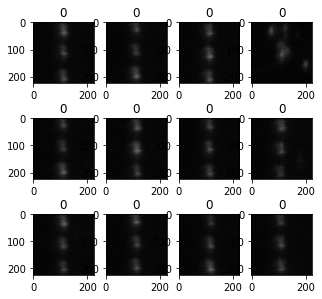

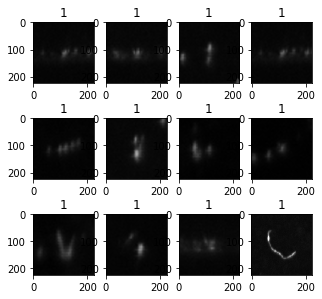

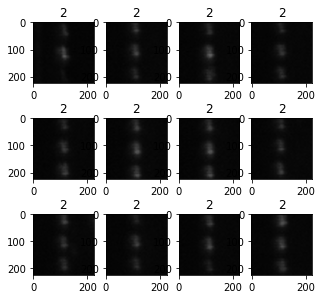

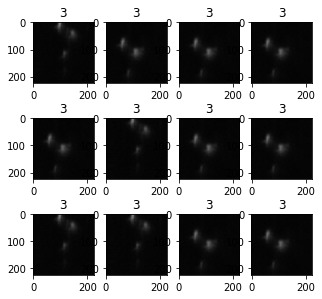

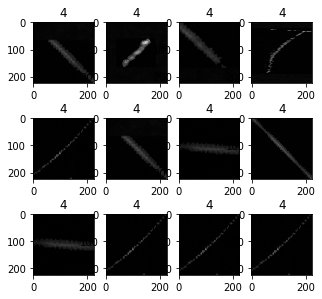

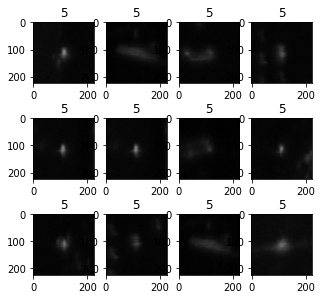

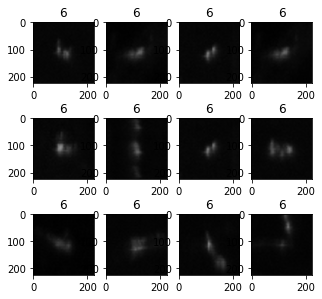

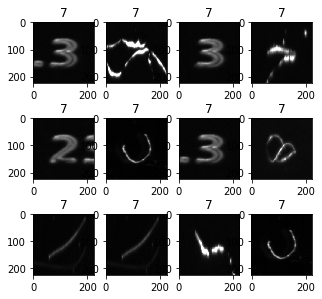

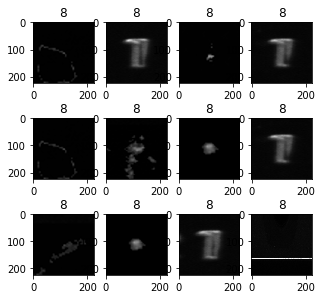

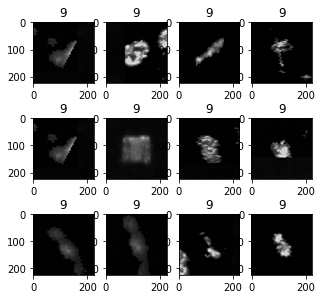

In [401]:
#plot_cluster(lable_pred,image_path,filenames,datas,bboxs)
#plot_cluster(lable_pred_def,image_path,filenames_def,datas_def,bboxs_def)
#plot_cluster(lable_pred_def1,image_path,filenames_def1,datas_def1,bboxs_def1)
#plot_cluster(lable_pred_def2,image_path,filenames_def2,datas_def2,bboxs_def2)
plot_cluster(lable_pred_def5,image_path,filenames_def5,datas_def5,bboxs_def5)

In [409]:
label_agg = aggCluster(Vgg_features_def5, classes_num = 10)

ordered corlab
[1 9 7 5 2 4 0]
ordered corlab
[3 1 6]
Defect 2 Correspondes to cluster: 6
Top 1 class: 6
Top1 acc: 0.68
Top 2 class: [1 6]
Top2 acc: 0.89
Top 3 class: [3 1 6]
Top3 acc: 1.00

Top 4 class: [3 1 6]
Top4 acc: 1.00

ordered corlab
[1 3 8 6]
Defect 3 Correspondes to cluster: 6
Top 1 class: 6
Top1 acc: 0.59
Top 2 class: [8 6]
Top2 acc: 0.87
Top 3 class: [3 8 6]
Top3 acc: 0.98

Top 4 class: [1 3 8 6]
Top4 acc: 1.00

ordered corlab
[6 8 3]
Defect 4 Correspondes to cluster: 3
Top 1 class: 3
Top1 acc: 0.40
Top 2 class: [8 3]
Top2 acc: 0.78
Top 3 class: [6 8 3]
Top3 acc: 1.00

Top 4 class: [6 8 3]
Top4 acc: 1.00

Top1 classes: [3 6]
Top2 classes: [1 3 6 8]
Top3 classes: [1 3 6 8]
Top4 classes: [1 3 6 8]


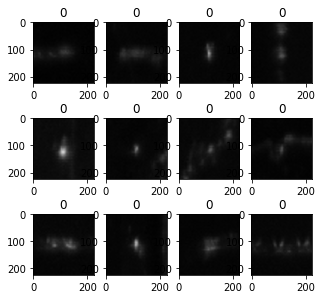

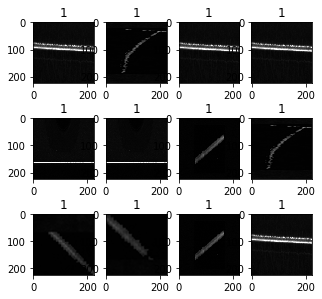

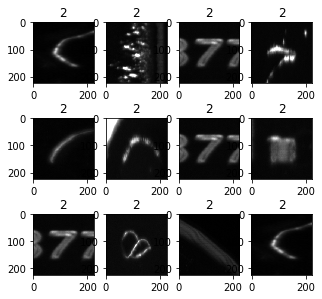

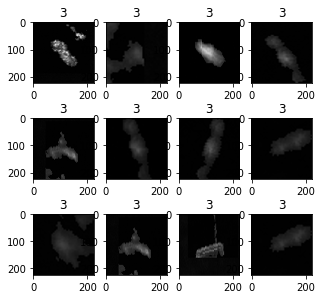

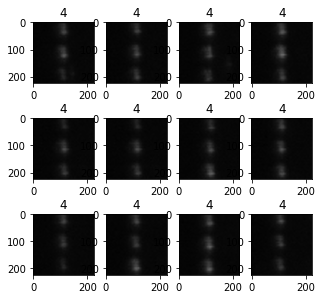

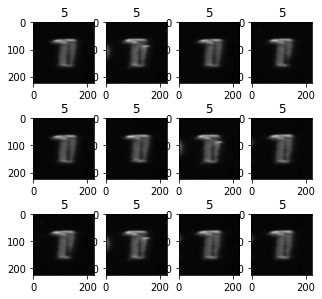

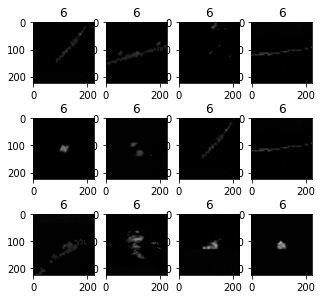

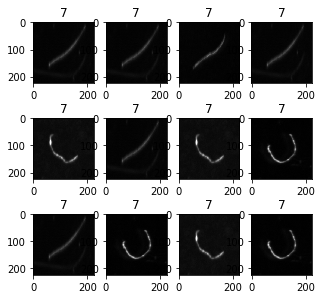

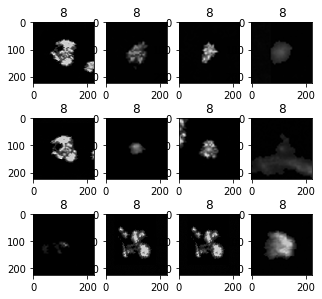

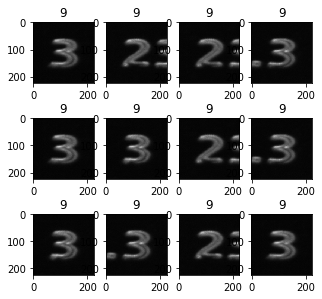

In [410]:
remined_classagg = get_lable_correspondence(lable_def5,label_agg)
plot_cluster(label_agg,image_path,filenames_def5,datas_def5,bboxs_def5)

In [465]:
Res_feat = np.concatenate( (Vgg_features_res,Vgg_features_res1,Vgg_features_res2,Vgg_features_res3,Vgg_features_res4), axis = 0 )
Res_lab = np.concatenate( (lable_res,lable_res1,lable_res2,lable_res3,lable_res4), axis = 0 ) [:,0]
Kep_feat = Vgg_features_def4
Kep_lab = lable_def4[:,0]

labres = np.zeros(Res_feat.shape[0])
labkep = np.zeros(Kep_feat.shape[0])+1


In [473]:
Res_feat = np.concatenate( (Vgg_features_res,Vgg_features_res1,Vgg_features_res2,Vgg_features_res3), axis = 0 )
Res_lab = np.concatenate( (lable_res,lable_res1,lable_res2,lable_res3), axis = 0 ) [:,0]
Kep_feat = Vgg_features_def3
Kep_lab = lable_def3[:,0]

labres = np.zeros(Res_feat.shape[0])
labkep = np.zeros(Kep_feat.shape[0])+1


In [19]:
Res_feat = np.concatenate( (Vgg_features_res,Vgg_features_res1,Vgg_features_res2), axis = 0 )
Res_lab = np.concatenate( (lable_res,lable_res1,lable_res2), axis = 0 ) [:,0]
Kep_feat = Vgg_features_def2
Kep_lab = lable_def2[:,0]

labres = np.zeros(Res_feat.shape[0])
labkep = np.zeros(Kep_feat.shape[0])+1

In [94]:
Kep_lab.shape

(7376,)

In [95]:
Res_lab.shape

(22093,)

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
clf = RandomForestClassifier(n_estimators=500, max_depth=None)
X = np.concatenate( (Kep_feat,Res_feat ), axis = 0 )
y = np.concatenate( (Kep_lab,Res_lab ), axis = 0 )
y_true = y = np.concatenate( (labkep,labres ), axis = 0 )
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
clf = RandomForestClassifier(n_estimators=500, max_depth=None,n_jobs = 8)

recalls = []
precisions = []
conM = []
aucs = []
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", len(train_index), "TEST:", len(test_index) )
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_true_train, y_true_test = y_true[train_index], y_true[test_index]
    clf.fit( X_train, y_train )
    y_pre = clf.predict( X_test )
    
    #print( accuracy_score(y_true_test, y_pre) )
    recalls.append(recall_score(y_true_test, y_pre, average='macro'))
    print("Recall")
    print( recalls[-1]   )#tp / (tp + fn)
    precisions.append(precision_score(y_true_test, y_pre, average='macro'))
    print("Precision")
    print( precisions[-1]  )# tp / (tp + fp)
    conM.append(confusion_matrix(y_true_test, y_pre))
    print('Confusion Matrix')
    print( conM[-1] )
    fpr, tpr, thresholds = metrics.roc_curve(y_true_test, y_pre, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    aucs.append(auc)
    print("Auc")
    print(aucs[-1])
    
clf.fit( X,y )
    
    
    
    
    
    



('TRAIN:', 23574, 'TEST:', 5895)
Recall
0.977074467792
Precision
0.988044469776
Confusion Matrix
[[4405   14]
 [  63 1413]]
Auc
0.977074467792
('TRAIN:', 23575, 'TEST:', 5894)
Recall
0.994911111878
Precision
0.990293807589
Confusion Matrix
[[4392   27]
 [   6 1469]]
Auc
0.994911111878
('TRAIN:', 23575, 'TEST:', 5894)
Recall
0.996608328443
Precision
0.995268873669
Confusion Matrix
[[4407   12]
 [   6 1469]]
Auc
0.996608328443
('TRAIN:', 23576, 'TEST:', 5893)
Recall
0.998981976659
Precision
0.997859671364
Confusion Matrix
[[4412    6]
 [   1 1474]]
Auc
0.998981976659
('TRAIN:', 23576, 'TEST:', 5893)
Recall
0.746733547659
Precision
0.694685503018
Confusion Matrix
[[2267 2151]
 [  29 1446]]
Auc
0.746733547659


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=8, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [439]:
np.average(aucs) # 5

0.93839198633830423

In [468]:
np.average(aucs) # 4

0.96415240078007647

In [475]:
np.average(aucs) # 3

0.96383666479413266

In [481]:
np.average(aucs) # 2

0.97929041691084928

In [22]:
np.average(aucs)

0.94286188648632674

In [59]:
defects_bool = labels[:,0] > 0
defects_ResNet_features  = ResNet_features[defects_bool]
defects_labels = labels[defects_bool] [:,0]

In [98]:
np.sum( defects_labels == 4 )

60

In [68]:
#clf_def = RandomForestClassifier(n_estimators=500, max_depth=None,n_jobs = 8)
from sklearn.linear_model import LogisticRegression
#clf_def = LogisticRegression()
clf_def = RandomForestClassifier(n_estimators=500, max_depth=None,n_jobs = 8)

In [92]:
def train_def_clf(X,y,clf):
    skf = StratifiedKFold(n_splits=5)
    skf.get_n_splits(X, y)
    clf = RandomForestClassifier(n_estimators=500, max_depth=None,n_jobs = 8)

    recalls = []
    precisions = []
    conM = []
    aucs = []
    for train_index, test_index in skf.split(X, y):
        print("TRAIN:", len(train_index), "TEST:", len(test_index) )
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit( X_train, y_train )
        y_pre = clf.predict( X_test )

        #print( accuracy_score(y_true_test, y_pre) )
        recalls.append(recall_score(y_test, y_pre, average='weighted'))
        print("Recall")
        print( recalls[-1]   )#tp / (tp + fn)
        precisions.append(precision_score(y_test, y_pre, average='weighted'))
        print("Precision")
        print( precisions[-1]  )# tp / (tp + fp)
        conM.append(confusion_matrix(y_test, y_pre))
        print('Confusion Matrix')
        print( conM[-1] )
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pre, pos_label=1)
        auc = metrics.auc(fpr, tpr)
        aucs.append(auc)
        #print("Auc")
        #print(aucs[-1])

    clf.fit( X,y )
    print("avg weighted recall:" + str(np.average(recalls)))
    print("avg weighted precision:" + str(np.average(precisions)))
    return clf

In [93]:
clf_def = train_def_clf(defects_ResNet_features,defects_labels,clf_def)

('TRAIN:', 122, 'TEST:', 32)
Recall
0.78125
Precision
0.798076923077
Confusion Matrix
[[ 6  2  0]
 [ 0  9  3]
 [ 0  2 10]]
('TRAIN:', 123, 'TEST:', 31)
Recall
0.774193548387
Precision
0.781054787506
Confusion Matrix
[[ 6  1  1]
 [ 1  7  3]
 [ 0  1 11]]
('TRAIN:', 123, 'TEST:', 31)
Recall
0.870967741935
Precision
0.897360703812
Confusion Matrix
[[ 8  0  0]
 [ 2  8  1]
 [ 1  0 11]]
('TRAIN:', 124, 'TEST:', 30)
Recall
0.866666666667
Precision
0.866666666667
Confusion Matrix
[[ 7  0  0]
 [ 0  9  2]
 [ 0  2 10]]
('TRAIN:', 124, 'TEST:', 30)
Recall
0.766666666667
Precision
0.766666666667
Confusion Matrix
[[ 4  2  1]
 [ 1  9  1]
 [ 2  0 10]]
avg weighted recall:0.811948924731
avg weighted precision:0.821965149546


In [23]:

test_img, test_preinfo = Crop_Test(image_path, "33.bmp", "33.bmp", save_path)
test_data, test_bbox, test_label, test_crops = test_preinfo
test_feats = transfer_feature_extractor(test_data,test_bbox,test_label,test_crops,root,"33.bmp",load=True)
test_Vgg_feat = test_feats.VggNet_feat
test_ResNet_feat = test_feats.ResNet_feat
test_label = test_feats.label

In [24]:
test_ResNet_feat.shape


(2486, 512)

In [25]:
test_pred_lable = clf.predict(test_ResNet_feat)

In [26]:
np.sum(test_pred_lable)

876.0

In [50]:
from joblib import load
lr = load('/app/lr.joblib')
rf = load('/app/rf.joblib')

lr_pred = lr.predict(test_ResNet_feat)
rf_pred = rf.predict(test_ResNet_feat)


In [72]:
clf_def_pred = clf_def.predict(test_ResNet_feat)

In [75]:
np.sum(clf_def_pred==4)

559

In [84]:
def plotImg_box_test( img, data, bbox, label, class_label ):
    plt.rcParams['figure.figsize'] = (40,20)

    fig,ax = plt.subplots(1)

    ax.imshow(img)
    markers = data
    x, y = zip(*markers)


    for i, lab in enumerate( label ):
        if lab > 0:
            xb, yb = data[i]
            w,h = bbox[i]
            

            rect = patches.Rectangle(( int(xb-w/2) , int(yb-h/2) ),w,h,linewidth=1,edgecolor='r',facecolor='none')
            
            if class_label[i] == 2:
                rect = patches.Rectangle(( int(xb-w/2) , int(yb-h/2) ),w,h,linewidth=1,edgecolor='red',facecolor='none')
            elif class_label[i] == 3: 
                rect = patches.Rectangle(( int(xb-w/2) , int(yb-h/2) ),w,h,linewidth=1,edgecolor='greenyellow',facecolor='none')
            elif class_label[i] == 4: 
                rect = patches.Rectangle(( int(xb-w/2) , int(yb-h/2) ),w,h,linewidth=1,edgecolor='orange',facecolor='none')
    
            ax.add_patch(rect)
    #ax.plot(x, y, '.')
    plt.show()

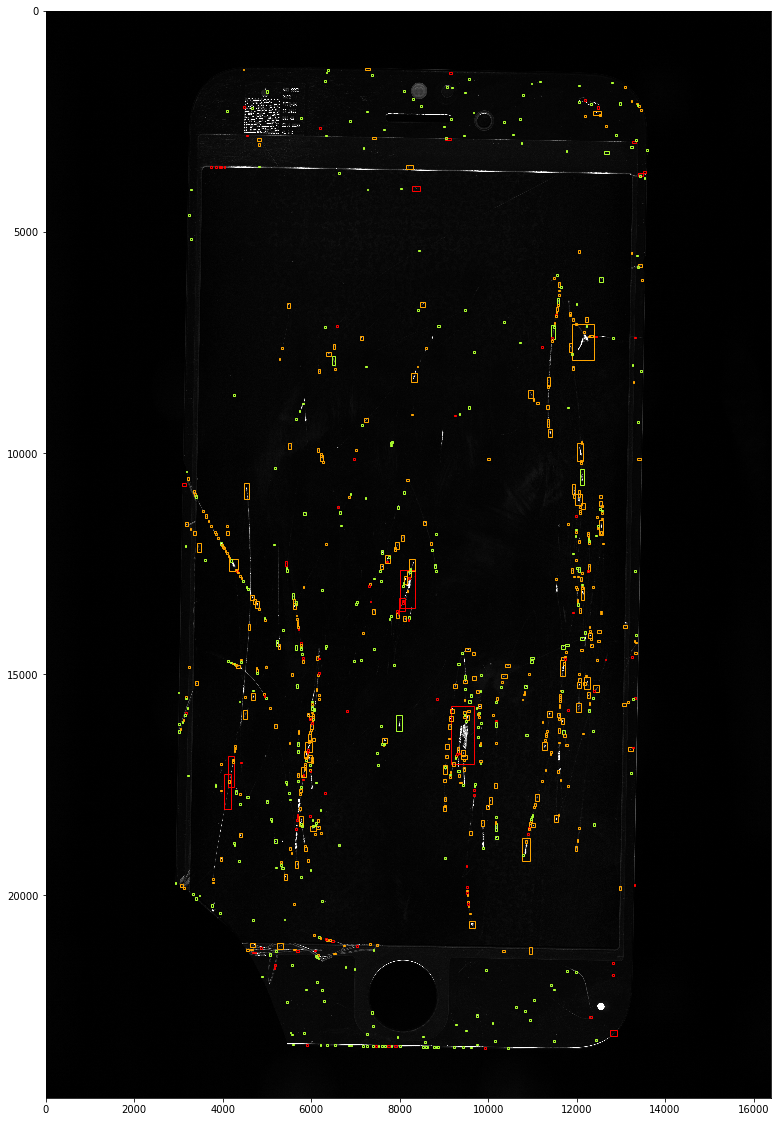

In [85]:
plotImg_box_test( test_img, test_data, test_bbox, test_pred_lable,clf_def_pred)

In [204]:
get_lable_correspondence(lable_def4,lable_pred_def4)

ordered corlab
[5 6 7 8 9 4 0 3 1]
ordered corlab
[9 2 5]
Defect 2 Correspondes to cluster: 5
Top 1 class: 5
Top1 acc: 0.50
Top 2 class: [2 5]
Top2 acc: 0.80
Top 3 class: [9 2 5]
Top3 acc: 1.00

Top 4 class: [9 2 5]
Top4 acc: 1.00

ordered corlab
[1 5 2]
Defect 3 Correspondes to cluster: 2
Top 1 class: 2
Top1 acc: 0.55
Top 2 class: [5 2]
Top2 acc: 0.82
Top 3 class: [1 5 2]
Top3 acc: 1.00

Top 4 class: [1 5 2]
Top4 acc: 1.00

ordered corlab
[1 5 2]
Defect 4 Correspondes to cluster: 2
Top 1 class: 2
Top1 acc: 0.95
Top 2 class: [5 2]
Top2 acc: 0.97
Top 3 class: [1 5 2]
Top3 acc: 1.00

Top 4 class: [1 5 2]
Top4 acc: 1.00

Top1 classes: [2 5]
Top2 classes: [2 5]
Top3 classes: [1 2 5 9]
Top4 classes: [1 2 5 9]


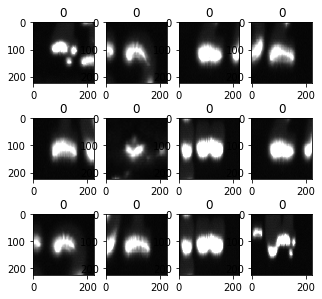

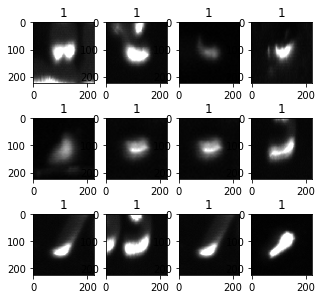

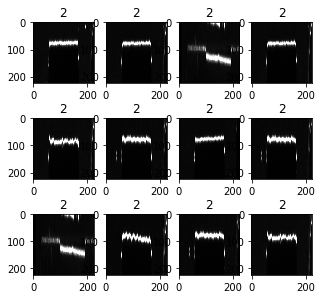

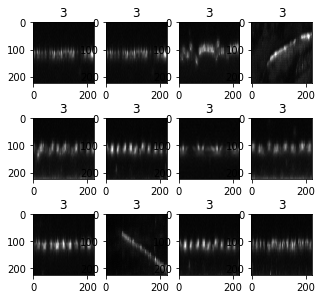

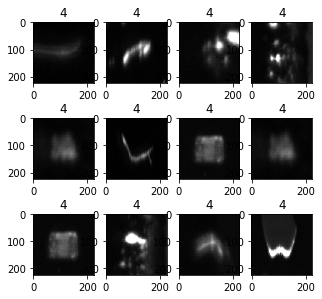

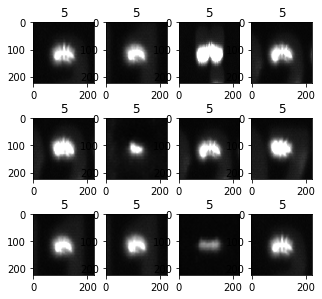

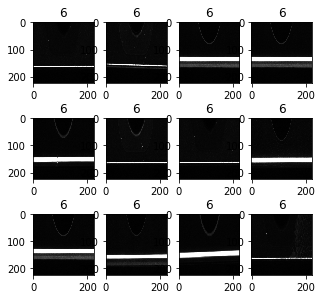

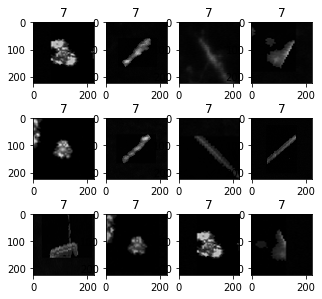

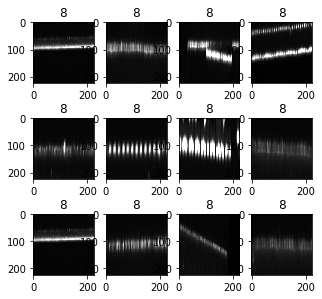

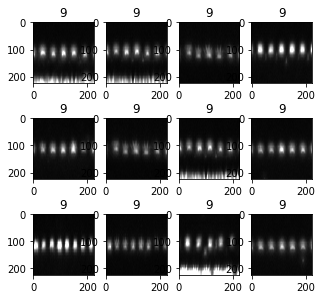

In [205]:
plot_cluster(lable_pred_def3,image_path,filenames_def3,datas_def3,bboxs_def3)

In [206]:
lable_pred4 = KmeansCluster(Vgg_features_def4,3)

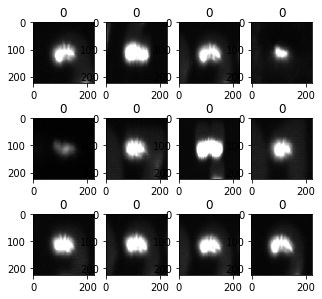

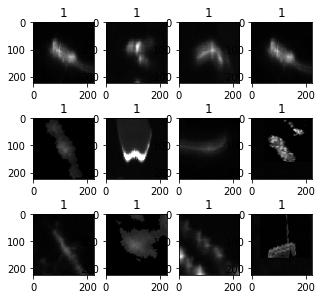

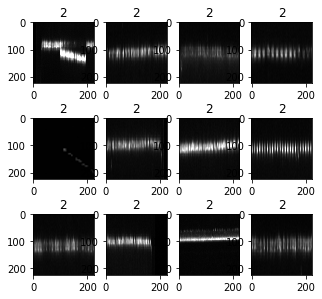

In [207]:
plot_cluster(lable_pred4,image_path,filenames_def4,datas_def4,bboxs_def4)

In [210]:
get_lable_correspondence(lable_def4,lable_pred4)

ordered corlab
[2 1 0]
ordered corlab
[2 1]
Defect 2 Correspondes to cluster: 1
Top 1 class: 1
Top1 acc: 0.90
Top 2 class: [2 1]
Top2 acc: 1.00
Top 3 class: [2 1]
Top3 acc: 1.00

Top 4 class: [2 1]
Top4 acc: 1.00

ordered corlab
[0 1]
Defect 3 Correspondes to cluster: 1
Top 1 class: 1
Top1 acc: 0.82
Top 2 class: [0 1]
Top2 acc: 1.00
Top 3 class: [0 1]
Top3 acc: 1.00

Top 4 class: [0 1]
Top4 acc: 1.00

ordered corlab
[0 1]
Defect 4 Correspondes to cluster: 1
Top 1 class: 1
Top1 acc: 0.97
Top 2 class: [0 1]
Top2 acc: 1.00
Top 3 class: [0 1]
Top3 acc: 1.00

Top 4 class: [0 1]
Top4 acc: 1.00

Top1 classes: [1]
Top2 classes: [0 1 2]
Top3 classes: [0 1 2]
Top4 classes: [0 1 2]


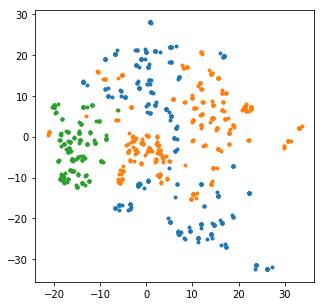

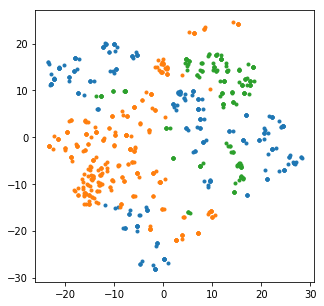

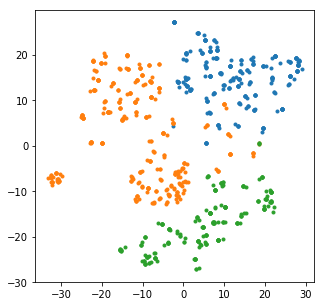

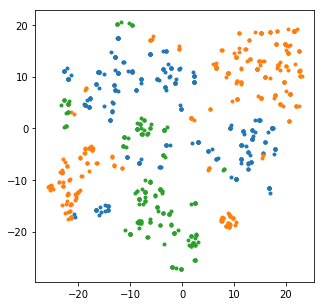

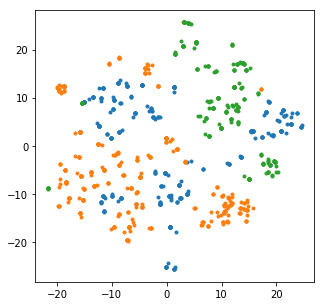

In [209]:
plotscattring( Vgg_features_def4 , 3, lable_pred4 )

In [217]:
lable_def4.shape
lable_def_4_copy = copy.deepcopy(lable_def4[:,0])
lable_def_4_copy[ lable_def_4_copy==0 ] = -1

In [260]:
np.sum(lable_def_4_copy==4)

37

In [275]:
from sklearn.semi_supervised import LabelSpreading
label_prop_model = LabelSpreading(kernel='knn',gamma=20,n_neighbors=2,alpha=0.2, max_iter=30)
label_prop_model.fit(Vgg_features_def4, lable_def_4_copy)
pre = label_prop_model.predict(Vgg_features_def4)
print(pre)


[4 4 3 2 3 4 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 4 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 4 4 3 4 4
 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 4 4 3 4 3 4 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 4 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 4 2 2 2 2 4 2 3 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 4 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 4 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 4 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 4 2 2 2 3 3 4 4 4 3 4 2 4]


In [283]:
from sklearn.cluster import AgglomerativeClustering
linkage =   'ward'#, 'average', 'complete', 'single'
clustering = AgglomerativeClustering(linkage=linkage, n_clusters=4)
res = clustering.fit_predict(Vgg_features_def4)
lable_def_4_agg = clustering.labels_

In [284]:
get_lable_correspondence(lable_def4,lable_def_4_agg)

ordered corlab
[3 1 0 2]
ordered corlab
[0 3]
Defect 2 Correspondes to cluster: 3
Top 1 class: 3
Top1 acc: 0.90
Top 2 class: [0 3]
Top2 acc: 1.00
Top 3 class: [0 3]
Top3 acc: 1.00

Top 4 class: [0 3]
Top4 acc: 1.00

ordered corlab
[3]
Defect 3 Correspondes to cluster: 3
Top 1 class: 3
Top1 acc: 1.00
Top 2 class: [3]
Top2 acc: 1.00
Top 3 class: [3]
Top3 acc: 1.00

Top 4 class: [3]
Top4 acc: 1.00

ordered corlab
[0 3]
Defect 4 Correspondes to cluster: 3
Top 1 class: 3
Top1 acc: 0.95
Top 2 class: [0 3]
Top2 acc: 1.00
Top 3 class: [0 3]
Top3 acc: 1.00

Top 4 class: [0 3]
Top4 acc: 1.00

Top1 classes: [3]


ValueError: all the input arrays must have same number of dimensions

In [160]:
np.sum(lable_def_3_copy == 4)

51

In [175]:
from sklearn.semi_supervised import LabelSpreading
label_prop_model = LabelSpreading(kernel='knn',n_neighbors=2,alpha=0.8, max_iter=10)
label_prop_model.fit(Vgg_features_def3, lable_def_3_copy)
pre = label_prop_model.predict(Vgg_features_def3)
print(pre)


[4 2 2 ..., 2 2 3]


In [176]:
label_prop_model.label_distributions_

array([[ 0.        ,  0.        ,  1.        ],
       [        nan,         nan,         nan],
       [        nan,         nan,         nan],
       ..., 
       [        nan,         nan,         nan],
       [        nan,         nan,         nan],
       [ 0.        ,  0.78571429,  0.21428571]])

In [157]:
print(1.*np.sum(pre==2)/len(pre) )

1.0


In [130]:
lable_pred4 = KmeansCluster(Vgg_features_def3,3)

In [212]:
plotscattring( Vgg_features_def3 , 10, lable_pred4 )

IndexError: index 482 is out of bounds for axis 1 with size 481

In [141]:
np.sum( lable_def3[:,0]==4 )

51

In [133]:
get_lable_correspondence(lable_def3,lable_pred4)

ordered corlab
[2 0 1]
ordered corlab
[2 1 0]
Defect 2 Correspondes to cluster: 0
Top 1 class: 0
Top1 acc: 0.57
Top 2 class: [1 0]
Top2 acc: 0.96
Top 3 class: [2 1 0]
Top3 acc: 1.00

Top 4 class: [2 1 0]
Top4 acc: 1.00

ordered corlab
[1 0 2]
Defect 3 Correspondes to cluster: 2
Top 1 class: 2
Top1 acc: 0.57
Top 2 class: [0 2]
Top2 acc: 0.97
Top 3 class: [1 0 2]
Top3 acc: 1.00

Top 4 class: [1 0 2]
Top4 acc: 1.00

ordered corlab
[2 0]
Defect 4 Correspondes to cluster: 0
Top 1 class: 0
Top1 acc: 0.98
Top 2 class: [2 0]
Top2 acc: 1.00
Top 3 class: [2 0]
Top3 acc: 1.00

Top 4 class: [2 0]
Top4 acc: 1.00



ValueError: all the input arrays must have same number of dimensions

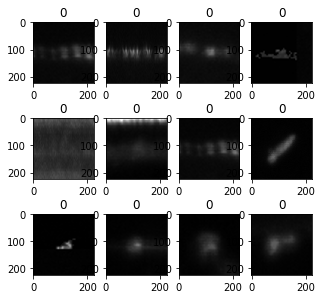

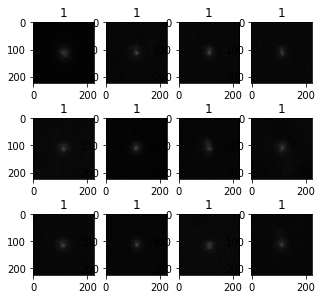

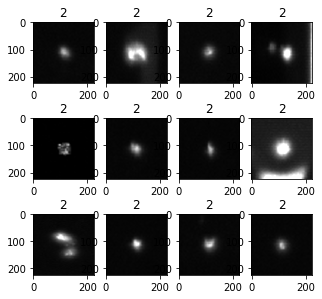

In [132]:
plot_cluster(lable_pred4,image_path,filenames_def3,datas_def3,bboxs_def3)

In [119]:
lable_pred3 = KmeansCluster(Vgg_features_def2,3)

In [124]:
get_lable_correspondence(lable_def2,lable_pred3)

ordered corlab
[2 1 0]
ordered corlab
[0 1 2]
Defect 2 Correspondes to cluster: 2
Top 1 class: 2
Top1 acc: 0.44
Top 2 class: [1 2]
Top2 acc: 0.85
Top 3 class: [0 1 2]
Top3 acc: 1.00

Top 4 class: [0 1 2]
Top4 acc: 1.00

ordered corlab
[2 1 0]
Defect 3 Correspondes to cluster: 0
Top 1 class: 0
Top1 acc: 0.57
Top 2 class: [1 0]
Top2 acc: 0.95
Top 3 class: [2 1 0]
Top3 acc: 1.00

Top 4 class: [2 1 0]
Top4 acc: 1.00

ordered corlab
[0 1]
Defect 4 Correspondes to cluster: 1
Top 1 class: 1
Top1 acc: 0.92
Top 2 class: [0 1]
Top2 acc: 1.00
Top 3 class: [0 1]
Top3 acc: 1.00

Top 4 class: [0 1]
Top4 acc: 1.00



ValueError: all the input arrays must have same number of dimensions

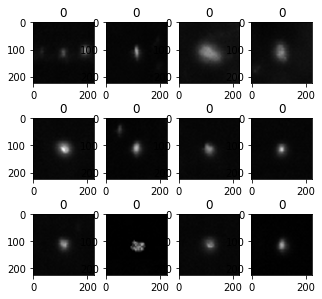

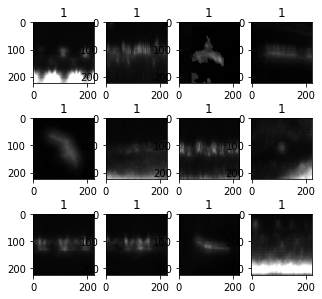

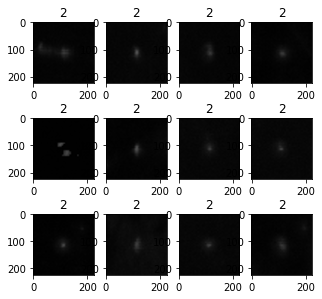

In [123]:


plot_cluster(lable_pred3,image_path,filenames_def2,datas_def2,bboxs_def2)

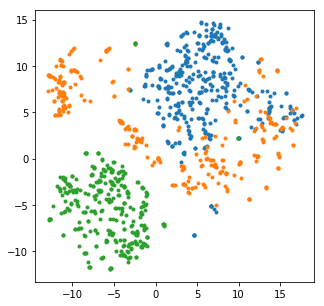

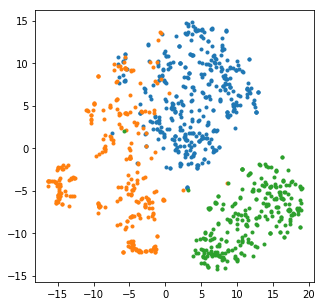

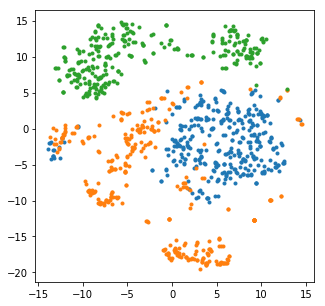

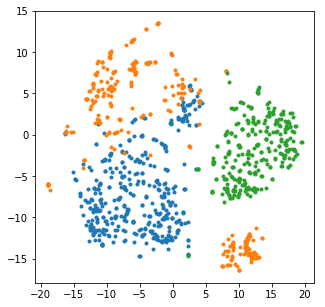

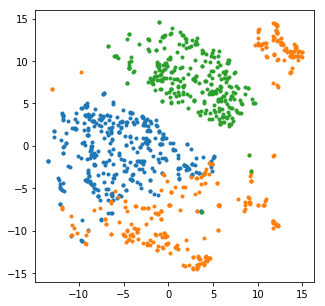

In [120]:
plotscattring( Vgg_features_def2 , 3, lable_pred3)

In [ ]:
for i,lab in enumerate( [1,4,6,7] ):
    if i == 0:
        defects_bool = lable_pred == lab
    else:
        defects_bool = np.logical_or( lable_pred == lab, defects_bool  )
print(lable_pred[defects_bool].shape)

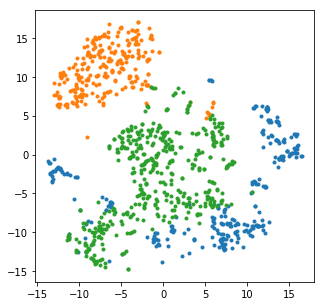

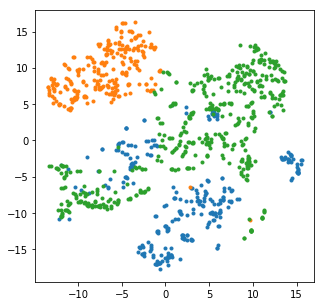

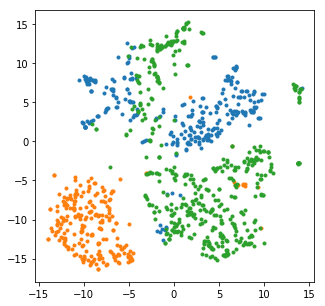

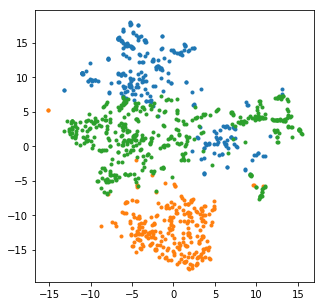

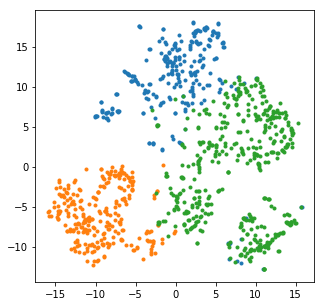

In [ ]:
filenames

In [25]:

for file in filename:
    gtfile = 'gt-'+file
    print(gtfile)
    
    start_time = time.time()

    img, gt, preinfo = Crop_Train(image_path, file,gtfile, save_path)
    data, bbox, label, crops = preinfo
    feats = transfer_feature_extractor(data,bbox,label,crops,root,file,load=True)
    
    
    plot_crops(label ,crops)
    plotImg_box(img, data,bbox, label)
    

    print("--- %s seconds ---" % (time.time() - start_time))

gt-10289_9100-22.bmp


NameError: name 'labels' is not defined

In [ ]:
data, bbox, label, crops

In [ ]:
xc = 4398; yc = 8101
plt.rcParams['figure.figsize'] = (10,10)
size = 50
plt.imshow( img[xc -size:xc+size,yc-size:yc+size] )
plt.show()
plt.imshow( dilation [xc -size:xc+size,yc-size:yc+size] )
plt.show()
plt.matshow( gt[xc -size:xc+size,yc-size:yc+size,0] )
plt.show()

In [ ]:
prepossing_img(image_path,'4957_10009-5137_4040-4398_8101-6.bmp', save_path)

In [ ]:
for file in filename:
    prepossing_img(image_path,file, save_path)
print('preprocessing is done')
    

In [ ]:
# In[14]:


data=np.array(data)
print(data.shape)
labels = range(1, 142)  
plt.figure(figsize=(10, 7))  
plt.subplots_adjust(bottom=0.1)  
plt.scatter(data[:,0],data[:,1], label='True Position')

for label, x, y in zip(labels, data[:, 0], data[:, 1]):  
    plt.annotate(
        label,
        xy=(x, y), xytext=(-3, 3),
        textcoords='offset points', ha='right', va='bottom')
plt.show()  

In [ ]:
# In[15]:


from scipy.cluster.hierarchy import dendrogram, linkage  
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import time
start = time.time()
linked = linkage(data, 'average')
labelList = range(1, np.array(data).shape[0]+1)

plt.figure(figsize=(10, 7))  
dendrogram(linked,  
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()  
c, coph_dists = cophenet(linked, pdist(data))
print (c)
# print(linked[0])
print('end',time.time()-start)

In [ ]:
# In[16]:



from scipy.cluster.hierarchy import fcluster
max_d = 3000
clusters = fcluster(linked, max_d, criterion='distance')
C=[]
W=[]
for i in range(max(clusters)):
    
    index = np.where(clusters==i+1)
    points = np.take(data,index,0)
    BB=points[0,:,:]
    #print(BB)
    mean=np.mean(BB,0)
    print(mean)
    C.append(mean)
    W.append(np.sqrt(np.var(BB,0)))
    print('var',np.sqrt(np.var(BB,0)))
C=np.array(C)
j=np.array([3600,3600])
imga = cv2.imread('33.bmp',1)

for i in C:
    print('i',int(i[0]),int(i[1]))
#     for j in centroids_b:
    cv2.rectangle(imga, (int(i[0])-j[0]/2, int(i[1])-j[1]/2), (int(i[0]) + j[0]/2, int(i[1]) + j[1]/2), (255, 0, 0), 8)
    #cv2.rectangle(imga, (50, 50), (5000, 5000), (222, 0, 0),5)
    cv2.circle(imga,(int(i[0]),int(i[1])),100,(55,255,155),-1)#修改最后一个参数
plt.figure(figsize=(30,30))
plt.imshow(imga)
    
    
    

In [ ]:
# In[17]:


import matplotlib.pyplot as plt  
get_ipython().run_line_magic('matplotlib', 'inline')
import numpy as np  
shape = data.shape  
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=3,affinity='l2', linkage='average',compute_full_tree='auto')  
A=cluster.fit_predict(data)  
plt.figure(figsize=(10, 7))  
plt.scatter(data[:,0], data[:,1], c=cluster.labels_, cmap='rainbow')  

In [ ]:
# In[23]:


print(A)
cluster.n_clusters
center = []
for i in range(cluster.n_clusters):
    index = np.where(A==i)
    points = np.take(data,index,0)
    BB=points[0,:,:]
    #print(BB)
    mean=np.mean(BB,0)
    print(mean)
    center.append(mean)
    print(np.sqrt(np.var(BB,0)))
    

In [ ]:
# In[24]:


print(center)
j=np.array([336,336])
for i in center:
#     for j in centroids_b:
    cv2.rectangle(img, (int(i[0])-int(j[0]/2), int(i[1])-int(j[1])/2), (int(i[0]) + int(j[0])/2, int(i[1]) + int(j[1])/2), (222, 0, 0), 1)
plt.figure(figsize=(20,20))
plt.imshow(a)

In [ ]:
# In[72]:


estimator=KMeans(n_clusters=4)
res=estimator.fit_predict(data)
lable_pred=estimator.labels_
centroids=estimator.cluster_centers_
inertia=estimator.inertia_
print (lable_pred)
print (centroids)
print (inertia)

# estimator_b=KMeans(n_clusters=3)
# res_b=estimator_b.fit_predict(data)
# lable_pred_b=estimator_b.labels_
# centroids_b=estimator_b.cluster_centers_
# inertia_b=estimator_b.inertia_
# print (lable_pred_b)
# print (centroids_b)
# print (inertia_b)


# In[49]:


centroids_b=np.array([[224,224],[336,336]])
print(centroids_b.shape)
for i in centroids:
    for j in centroids_b:
        cv2.rectangle(img, (int(i[0])-int(j[0]/2), int(i[1])-int(j[1])/2), 
                      (int(i[0]) + int(j[0])/2, int(i[1]) + int(j[1])/2), (222, 111, 0), 1)
plt.figure(figsize=(20,20))
plt.imshow(a)